# Survival Analysis

## Imports

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from lifelines import KaplanMeierFitter
from lifelines.plotting import plot_lifetimes 
from lifelines import CoxPHFitter   
%pylab inline
figsize(12,6)

Populating the interactive namespace from numpy and matplotlib


### Example with a fictitious data

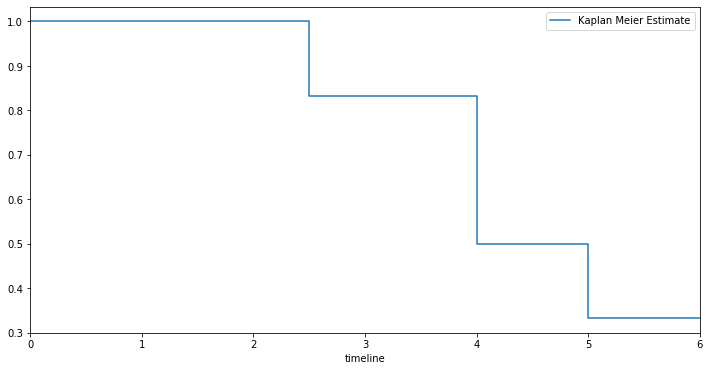

In [24]:
durations = [5,6,6,2.5,4,4]
event_observed = [1, 0, 0, 1, 1, 1]

kmf = KaplanMeierFitter() 
kmf.fit(durations, event_observed,label='Kaplan Meier Estimate')
kmf.plot(ci_show=False);

## Real World Example 

### Load data

We will be using Telco Customer Churn data from Kaggle https://www.kaggle.com/blastchar/telco-customer-churn/

In [25]:
df = pd.read_csv('D:/data/csv/Telco-Customer-Churn.csv') 
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


### Data cleansing

In [26]:
print(df.info())

# Convert TotalCharges to numeric
df['TotalCharges']=pd.to_numeric(df['TotalCharges'],errors='coerce')

# Replace yes and No in the Churn column to 1 and 0. 1 for the event and 0 for the censured data.
df['Churn']=df['Churn'].apply(lambda x: 1 if x == 'Yes' else 0 )

print('\nAfter cleansing\n')
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
customerID          7043 non-null object
gender              7043 non-null object
SeniorCitizen       7043 non-null int64
Partner             7043 non-null object
Dependents          7043 non-null object
tenure              7043 non-null int64
PhoneService        7043 non-null object
MultipleLines       7043 non-null object
InternetService     7043 non-null object
OnlineSecurity      7043 non-null object
OnlineBackup        7043 non-null object
DeviceProtection    7043 non-null object
TechSupport         7043 non-null object
StreamingTV         7043 non-null object
StreamingMovies     7043 non-null object
Contract            7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null object
Churn               7043 non-null object
dtypes: float64(1), int64(2), obj

In [28]:
# Impute the null value with the median value
df.TotalCharges.fillna(value=df['TotalCharges'].median(),inplace=True)

# Create a list of Categorical Columns
cat_cols= [i  for i in df.columns if df[i].dtype==object]
cat_cols.remove('customerID')  ## customerID has been removed because it is unique for all the rows.

# lets have a look at the categories and their distribution in all the categorical columns.
for i in cat_cols:
    print('Column Name: ',i)
    print(df[i].value_counts())
    print('-----------------------------')

Column Name:  gender
Male      3555
Female    3488
Name: gender, dtype: int64
-----------------------------
Column Name:  Partner
No     3641
Yes    3402
Name: Partner, dtype: int64
-----------------------------
Column Name:  Dependents
No     4933
Yes    2110
Name: Dependents, dtype: int64
-----------------------------
Column Name:  PhoneService
Yes    6361
No      682
Name: PhoneService, dtype: int64
-----------------------------
Column Name:  MultipleLines
No                  3390
Yes                 2971
No phone service     682
Name: MultipleLines, dtype: int64
-----------------------------
Column Name:  InternetService
Fiber optic    3096
DSL            2421
No             1526
Name: InternetService, dtype: int64
-----------------------------
Column Name:  OnlineSecurity
No                     3498
Yes                    2019
No internet service    1526
Name: OnlineSecurity, dtype: int64
-----------------------------
Column Name:  OnlineBackup
No                     3088
Yes     

### Global Kaplan-Meier

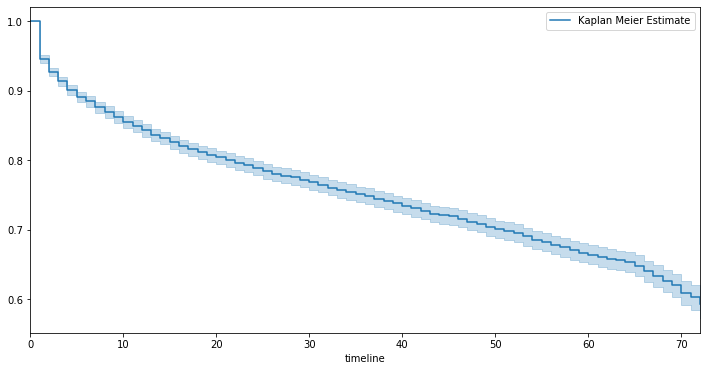

In [30]:
## Lets create an overall KaplanMeier curve, without breaking it into groups of covariates.

## Import the library
from lifelines import KaplanMeierFitter


durations = df['tenure'] ## Time to event data of censored and event data
event_observed = df['Churn']  ## It has the churned (1) and censored is (0)

## create a kmf object as km
km = KaplanMeierFitter() ## instantiate the class to create an object

## Fit the data into the model
km.fit(durations, event_observed,label='Kaplan Meier Estimate')

## Create an estimate
km.plot();

### Kaplan-Meier for Cohorts

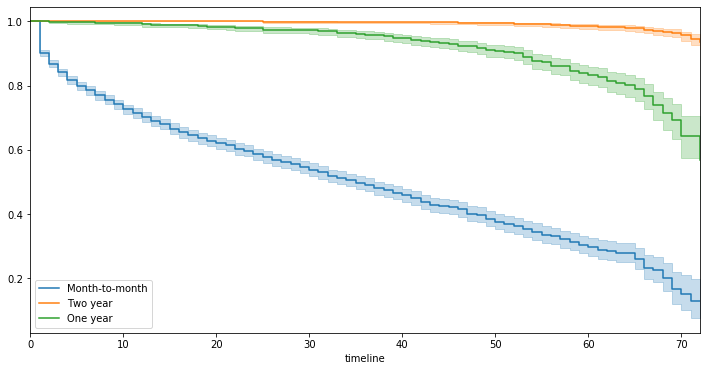

In [31]:
kmf = KaplanMeierFitter() 


T = df['tenure']     ## time to event
E = df['Churn']      ## event occurred or censored


groups = df['Contract']             ## Create the cohorts from the 'Contract' column
ix1 = (groups == 'Month-to-month')   ## Cohort 1
ix2 = (groups == 'Two year')         ## Cohort 2
ix3 = (groups == 'One year')         ## Cohort 3


kmf.fit(T[ix1], E[ix1], label='Month-to-month')    ## fit the cohort 1 data
ax = kmf.plot()


kmf.fit(T[ix2], E[ix2], label='Two year')         ## fit the cohort 2 data
ax1 = kmf.plot(ax=ax)


kmf.fit(T[ix3], E[ix3], label='One year')        ## fit the cohort 3 data
kmf.plot(ax=ax1)                                 ## Plot the KM curve for three cohort on same x and y axis

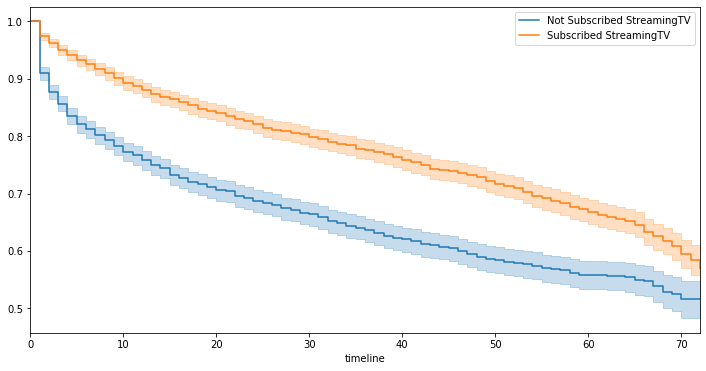

In [33]:
kmf1 = KaplanMeierFitter() # instantiate the class to create an object

# Two Cohorts are compared. 1. Streaming TV Not Subsribed by Users, 2. Streaming TV subscribed by the users.
groups = df['StreamingTV']   
i1 = (groups == 'No')      # group i1 , having the pandas series for the 1st cohort
i2 = (groups == 'Yes')     # group i2 , having the pandas series for the 2nd cohort


# fit the model for 1st cohort
kmf1.fit(T[i1], E[i1], label='Not Subscribed StreamingTV')
a1 = kmf1.plot()

# fit the model for 2nd cohort
kmf1.fit(T[i2], E[i2], label='Subscribed StreamingTV')
kmf1.plot(ax=a1);

### Cox Proportional Hazards

In [35]:
# subset of the columns to train the model
df_r= df.loc[:,['tenure','Churn','gender','Partner','Dependents','PhoneService','MonthlyCharges','SeniorCitizen','StreamingTV']]
df_r.head()

,tenure,Churn,gender,Partner,Dependents,PhoneService,MonthlyCharges,SeniorCitizen,StreamingTV
0,1,0,Female,Yes,No,No,29.85,0,No
1,34,0,Male,No,No,Yes,56.95,0,No
2,2,1,Male,No,No,Yes,53.85,0,No
3,45,0,Male,No,No,No,42.30,0,No
4,2,1,Female,No,No,Yes,70.70,0,No


In [36]:
# Create dummy variables
df_dummy = pd.get_dummies(df_r, drop_first=True)
df_dummy.head()

,tenure,Churn,MonthlyCharges,SeniorCitizen,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,StreamingTV_No internet service,StreamingTV_Yes
0,1,0,29.85,0,0,1,0,0,0,0
1,34,0,56.95,0,1,0,0,1,0,0
2,2,1,53.85,0,1,0,0,1,0,0
3,45,0,42.30,0,1,0,0,0,0,0
4,2,1,70.70,0,0,0,0,1,0,0


In [37]:
# Using Cox Proportional Hazards model
cph = CoxPHFitter()   ## Instantiate the class to create a cph object
cph.fit(df_dummy, 'tenure', event_col='Churn')   ## Fit the data to train the model
cph.print_summary()    ## HAve a look at the significance of the features

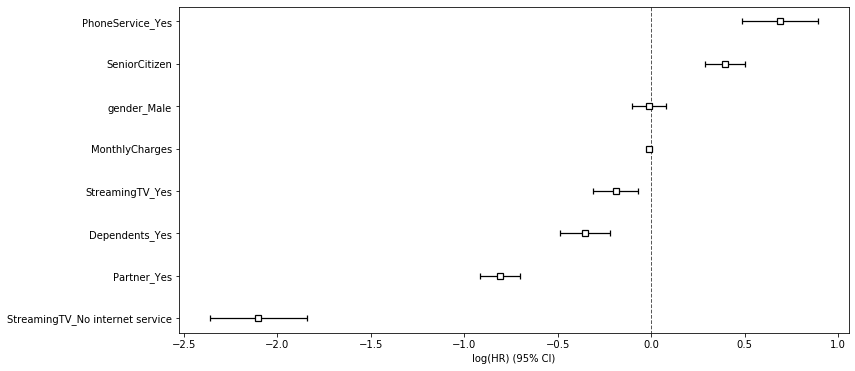

In [38]:
cph.plot();

In [39]:
## Check all the methods and attributes associated with the cph object.
dir(cph)

['_KNOWN_MODEL',
 '__annotations__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_batch_mode',
 '_censoring_type',
 '_check_values_post_fitting',
 '_check_values_pre_fitting',
 '_class_name',
 '_clusters',
 '_compute_baseline_cumulative_hazard',
 '_compute_baseline_hazard',
 '_compute_baseline_hazards',
 '_compute_baseline_survival',
 '_compute_confidence_intervals',
 '_compute_delta_beta',
 '_compute_deviance',
 '_compute_martingale',
 '_compute_p_values',
 '_compute_sandwich_estimator',
 '_compute_scaled_schoenfeld',
 '_compute_schoenfeld',
 '_compute_schoenfeld_within_strata',
 '_compute_score',
 '_compute_score_within_strata',
 '_compute_standard_errors',
 '_c

In [40]:
## To see the Survival curve at the customer level we selected 6 customers (rows 5 till 9).

tr_rows = df_dummy.iloc[5:10, 2:]
tr_rows

,MonthlyCharges,SeniorCitizen,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,StreamingTV_No internet service,StreamingTV_Yes
5,99.65,0,0,0,0,1,0,1
6,89.10,0,1,0,1,1,0,1
7,29.75,0,0,0,0,0,0,0
8,104.80,0,0,1,0,1,0,1
9,56.15,0,1,0,1,1,0,0


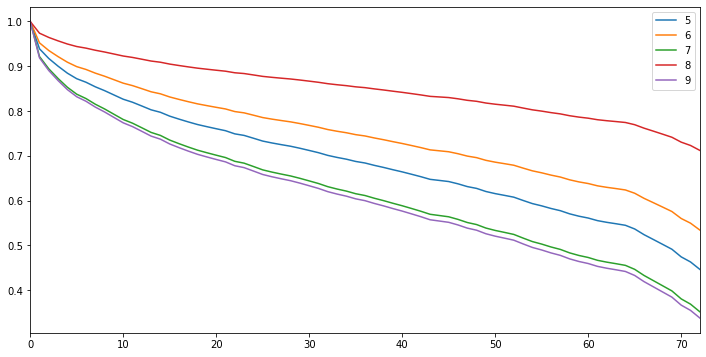

In [42]:
# Lets predict the survival curve for the selected customers. Customers can be identified with the help of the number mentioned against each curve.
cph.predict_survival_function(tr_rows).plot();

## Credits & Links

https://github.com/anurag-code/Survival-Analysis-Intuition-Implementation-in-Python
https://towardsdatascience.com/survival-analysis-intuition-implementation-in-python-504fde4fcf8e